**Stock Market Forecasting: A Comparative Study of ARIMA, CNN and LSTM on S&P 500**

This project plan sets the stage for a comprehensive exploration of stock market forecasting, underpinned by a meticulously crafted timeline and robust management strategy. By comparing the efficacy of ARIMA, CNN and LSTM models in predicting the S&P 500 index for a 90 period, we aim to distill algorithmic insights into actionable strategies for investors and financial analysts.

In [1]:
# Importing Necessary Libraries for our Prediction


import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, History
import math
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import random


from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7.5]
!pip install pmdarima

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import itertools


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# fetching the SPDR S&P 500 ETF data from Yahoo Finance form the period of Janauary 2019 to May 2024
ticker = 'SPY'  # Ticker for SPDR S&P 500 ETF Trust
sp500_data = yf.download(ticker, start="2019-07-01", end="2024-06-30")
print(sp500_data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-07-01  296.679993  296.920013  294.329987  295.660004  273.265656   
2019-07-02  295.609985  296.489990  294.679993  296.429993  273.977386   
2019-07-03  297.179993  298.820007  297.019989  298.799988  276.167877   
2019-07-05  297.440002  298.640015  296.010010  298.459991  275.853638   
2019-07-08  297.010010  298.257904  296.220001  296.820007  274.337921   
...                ...         ...         ...         ...         ...   
2024-06-24  544.330017  546.950012  542.619995  542.739990  542.739990   
2024-06-25  543.989990  545.200012  542.440002  544.830017  544.830017   
2024-06-26  543.690002  546.239990  543.030029  545.510010  545.510010   
2024-06-27  545.369995  546.960022  544.609985  546.369995  546.369995   
2024-06-28  547.159973  550.280029  542.950012  544.219971  544.219971   

              Volume  
Date          

                 Close
Date                  
2019-07-01  295.660004
2019-07-02  296.429993
2019-07-03  298.799988
2019-07-05  298.459991
2019-07-08  296.820007


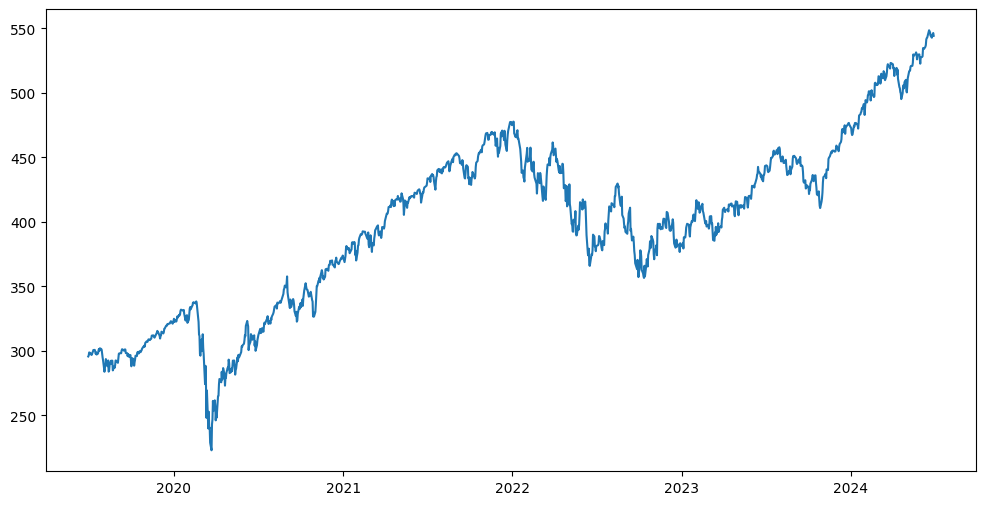

In [4]:
# Extracting the Closing price column only which we will be using for our prediction
data = sp500_data[['Close']]
print(data.head())


# Exploring the stock data to get insights about the data
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])

The graph aboves reveals that S&P 500 stock has a fluctuating pattern and trend.

It can also be deduced from the fluctuating pattern that the stock is non stationary in nature which is an important feature for predicting time series data using traditional methods .

In [5]:
# performing descriptive statistics
data.describe()

,Close
count,1258.000000
mean,397.562910
std,66.587275
min,222.949997
25%,339.550011
50%,406.755005
75%,443.367493
max,548.489990


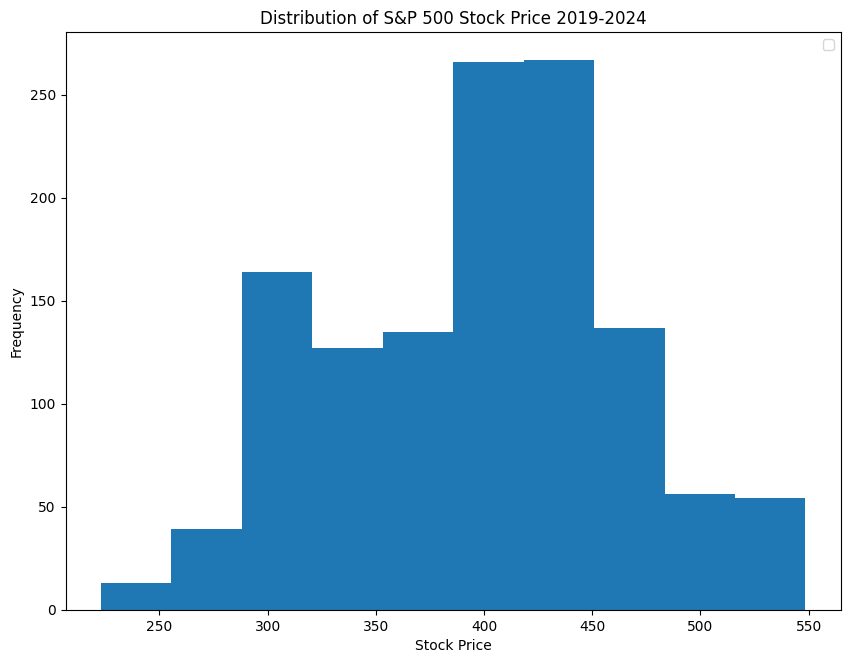

In [6]:
# Plotting histogram to undertand the distribution of the data

plt.hist(data['Close'])
plt.title('Distribution of S&P 500 Stock Price 2019-2024')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
# Performing Feature Engineering on the data to create a year and month columns for data exploration

data.loc[:, 'Year'] = data.index.year
data.loc[:, 'Month'] = data.index.strftime('%b')
data.loc[:, 'Day'] = data.index.strftime('%a')

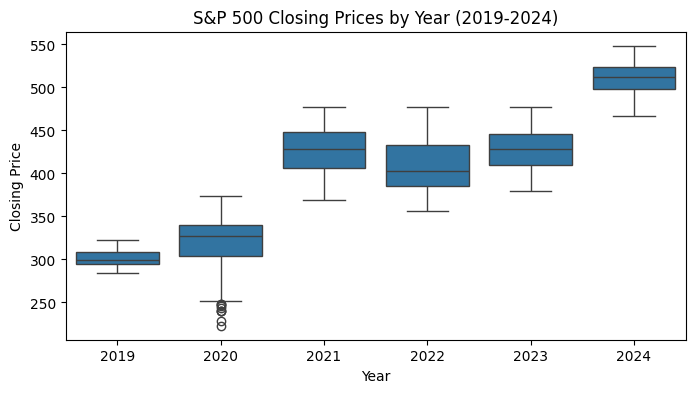

In [8]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x='Year', y='Close')
plt.title('S&P 500 Closing Prices by Year (2019-2024)')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

From the boxplot above, we can deduce that the year 2024 has the higest median stock price(higest trend price). and year 2019 experienced the lowest median stock price(lowest trend price)

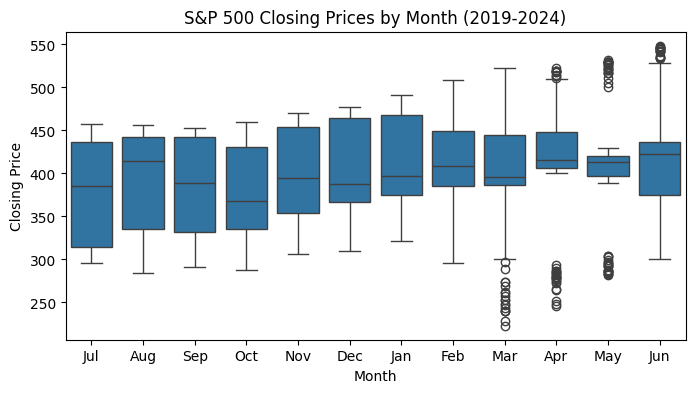

In [9]:
palette = sns.color_palette("husl", 12)
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x='Month', y='Close')
plt.title('S&P 500 Closing Prices by Month (2019-2024)')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.show()

The box plot of the S&P 500 closing prices over a 5-year period reveals several key insights. March and April exhibit some of the highest median closing prices, while February and March show some of the lowest median prices, suggesting potential market dips during these months. The variation within months indicates that April and March experience a large number of outliers, highlighting high volatility during these periods. In contrast, months such as December, January, and February display relatively less variation and fewer outliers, indicating greater market stability.

Market insights from this data suggest that the market experiences higher volatility in the spring (March and April) and tends to be more stable towards the end of the year and in the winter months (November to January).

**Good insigts We got from the exploratory analysis. We will now move to preprocessing and make our data suitable for prediction. First, we will scale the data using MinMax Scaler to mormalize our data to be between the values of 0 amd 1 so that there are in uniform range. This is important so that our model will perform optimally**

**Also, the data will be splitted in a 80-20 ratio, 80% of the data will be used for training our model and the remaing 20% will be used for assessing the performance of our model**

In [10]:
# Selecting only the closing price as that is what will be used for building our model and prediction
data2 = data[['Close']]

# Prepocessing the data so it can be suitable for Deep learning
scaler = MinMaxScaler()
scaled_data =scaler.fit_transform(data2['Close'].values.reshape(-1,1))

# splitting the data into training and testing
train_size = int(len(scaled_data) * 0.80) # size of training data is 80% of the total data
test_size = len(scaled_data) - train_size # size of testing data which will be 20%

#train_data, test_data = scaled_data[:train_size,:], scaled_data[train_size:,:]
train_data,test_data = scaled_data[0:train_size,:],scaled_data[train_size:len(scaled_data),:]
train_data.shape, test_data.shape

scaled_data

array([[0.22335199],
       [0.22571726],
       [0.23299746],
       ...,
       [0.99084604],
       [0.99348776],
       [0.98688327]])

# **LSTM Model**

LSTM Model deals with sequence of data in prediction. That is the model learns to predict the next values in the sequence based on past data. As a result, the model wont have an explict target column.hence, we will have to create the sequnce in which the model will use past data to predict target values as shown in the next line of code. We will employ the use of timeseriesgenerator for this

In [11]:
# number of previous time steps(sequence of time) to use before making prediction on the next one
steps=30

#creating a sequence of data that uses 30 past data(X) to make prediction(y)
train_generator= TimeseriesGenerator(train_data,train_data, length=steps, batch_size=20)
test_generator= TimeseriesGenerator(test_data, test_data, length=steps, batch_size=2)

# **BUILDING AND TRAINING THE LSTM  MODEL**

After defining the sequence of time for our prediction, next step is building our model for prediction as seen below

In [12]:


np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)



# Building a Sequential LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=30, return_sequences=True, input_shape=(30,1)))
lstm_model.add(LSTM(units=60, return_sequences=True))
lstm_model.add(LSTM(units=60))
lstm_model.add(Dense(1))

# compiling the model
lstm_model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training the model on the training data and assessing  its performance on the validation data
lstm_model.fit(train_generator, epochs=100, batch_size=20)



Epoch 1/100
49/49 [==============================] - 14s 20ms/step - loss: 0.0251 - mean_absolute_error: 0.0953
Epoch 2/100
49/49 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0433
Epoch 3/100
49/49 [==============================] - 1s 22ms/step - loss: 0.0024 - mean_absolute_error: 0.0362
Epoch 4/100
49/49 [==============================] - 1s 23ms/step - loss: 0.0017 - mean_absolute_error: 0.0304
Epoch 5/100
49/49 [==============================] - 1s 22ms/step - loss: 0.0028 - mean_absolute_error: 0.0354
Epoch 6/100
49/49 [==============================] - 2s 30ms/step - loss: 0.0024 - mean_absolute_error: 0.0367
Epoch 7/100
49/49 [==============================] - 2s 40ms/step - loss: 0.0020 - mean_absolute_error: 0.0335
Epoch 8/100
49/49 [==============================] - 1s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0300
Epoch 9/100
49/49 [==============================] - 1s 19ms/step - loss: 0.0025 - mean_absolute_error: 0.0380


Dispalying the Model Architecture  and Summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 60)            21840     
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 54781 (213.99 KB)
Trainable params: 54781 (213.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


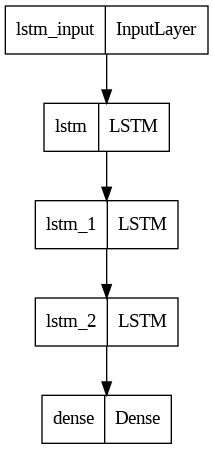

In [13]:
# Display the model summary
lstm_model.summary()

# Plotting the model
plot_model(lstm_model)

Having Built our Model and Trained in on our Training data, We will move on to using the LSTM model to predict on our test data

In [14]:
# Predicting on the test data
lstm_predictions = lstm_model.predict(test_generator)


111/111 [==============================] - 2s 6ms/step


Recall that to ensure our data are within the same values so that the model will treat all values the same and the larger ones wont dominate the smaller values, we scaled our values to be within 0 and 1 using the MinMaxScaler. Now, we will inverse the values so that our data are in its original form

In [15]:
# Invert predictions
lstm_prediction = scaler.inverse_transform(lstm_predictions)
actual_prices = scaler.inverse_transform(test_data[steps:])


Lets see the predicted and actual values in a tabular format

In [16]:
# Showcasing s&p 500 actual price vs the predicted price
lstm_predict_vs_actual=pd.DataFrame({'Actual stock price': actual_prices.flatten(), 'LSTM Predicted stock price':lstm_prediction.flatten()})
print(lstm_predict_vs_actual)

     Actual stock price  LSTM Predicted stock price
0            445.649994                  447.113586
1            448.109985                  446.608154
2            442.890015                  449.642548
3            439.640015                  442.561676
4            436.290009                  440.512604
..                  ...                         ...
217          542.739990                  542.704651
218          544.830017                  542.028564
219          545.510010                  545.930603
220          546.369995                  544.474854
221          544.219971                  546.121155

[222 rows x 2 columns]


## LSTM MODEL EVALUATION

Lets now evaluate the model performance and predictive accuracy using MAE, RMSE and R2

In [17]:
# Evaluating the model using Mean Absolute Error
mae=mean_absolute_error(actual_prices,lstm_prediction)

# Evaluating the model using Root Mean Square Error
mse=mean_squared_error(actual_prices,lstm_prediction)
rmse=mse**(1/2)

# Evaluating the model using Root Mean Square Error
r2=r2_score(actual_prices,lstm_prediction)

print(f'the Mean Absolute Error: {mae}')
print(f'the Root Mean Square Error is {rmse}')
print(f'the Rsquare is {round(r2 *100)}')


the Mean Absolute Error: 2.8141588090776315
the Root Mean Square Error is 3.5911944145227883
the Rsquare is 99


# **Interpreting the evaluation metrics reveals the following:**

Our Model MAE score of 2.86 indicates that the average difference between the actual and predicted S&P 500 closing price will be $2.86.

Our Model RMSE score of 3.65 indicates that the average difference between the actual and predicted S&P 500 closing price will be $3.65. It is important to note that the RMSE score penalizes large errors, hence the larger RMSE score.

The R^2 score indicates the predictive power of our model and the degree to which our model explains the variability of our dependent variable. Hence, an R^2 score of 99% indicates that the predictive power of our model is 99% and that 99% of the variance in the dependent variable is explained by the model.






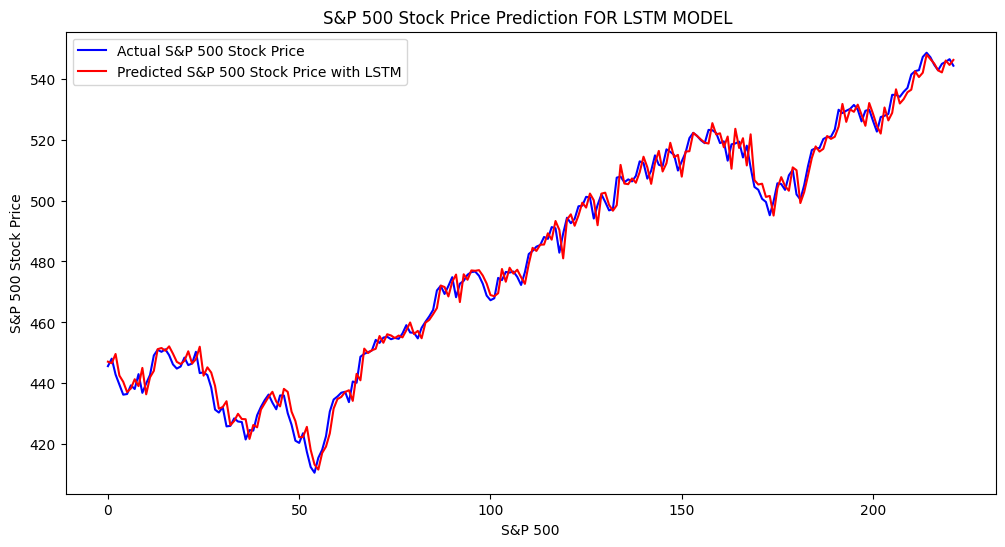

In [18]:
# Plotting a lineplot to visualize our actual and predicted values
plt.figure(figsize=(12,6))
plt.plot(actual_prices, color='blue', label='Actual S&P 500 Stock Price')
plt.plot(lstm_prediction, color='red', label='Predicted S&P 500 Stock Price with LSTM')
plt.title('S&P 500 Stock Price Prediction FOR LSTM MODEL ')
plt.xlabel('S&P 500')
plt.ylabel('S&P 500 Stock Price')
plt.legend()
plt.show()

# **FORECASTING WITH OUR LSTM MODEL FOR A 90 DAYS PERIOD**

Having build our LSTM model and evaluated the performance using the test data, we will now use the LSTM model to predict S&P 500 stock price for the next 90 days

In [19]:
# Creating a Def Function to predict the next 90 days

def predict_future_days(model, base_data, days_to_predict, scaler, look_back):
    # Ensure the base_data is correctly shaped for the model input
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # List to store future predictions
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction using the model
        prediction = model.predict(input_data)

        # Append the prediction to the future_predictions list
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling to get the predictions back to the original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions.flatten()



In [20]:
# Predict next 90 days
look_back = 30
days_to_predict = 90
future_days = predict_future_days(lstm_model, scaled_data, days_to_predict, scaler, look_back)

1/1 [==============================] - 0s 23ms/step


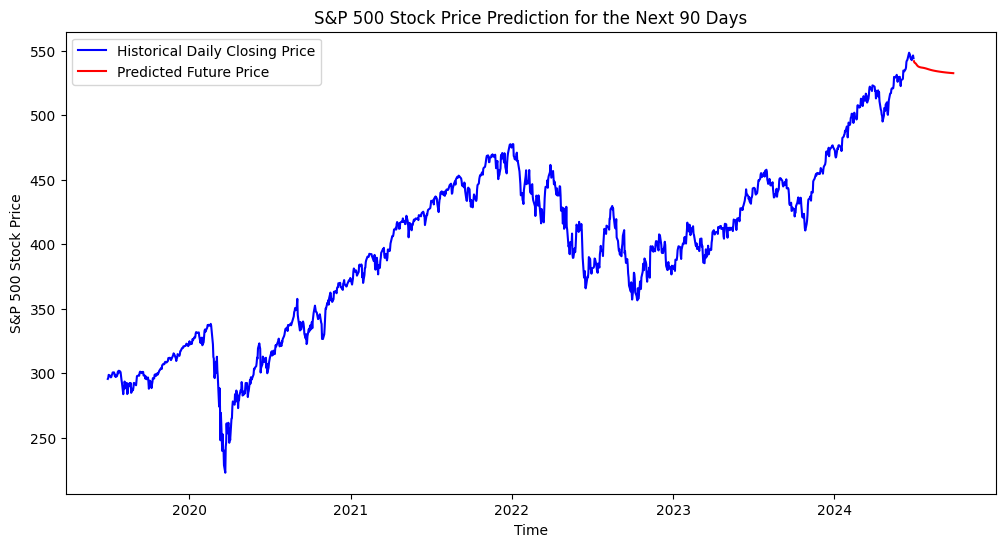

In [21]:
# Plot the predictions
predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, freq='D')[1:]
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], color='blue', label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price')
plt.title(f'S&P 500 Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('S&P 500 Stock Price')
plt.legend()
plt.show()

The red line represents the forecasted S&P 500 closing prices for the next 90 days beyond the last date of the historical data.
The forecast shows a slight downward trend, suggesting that the model anticipates a minor decline in the S&P 500 index over the upcoming 90 days

# CNN MODEL

In [22]:
# Set Random Seeds:

np.random.seed(52)
tf.random.set_seed(52)
random.seed(52)

# Define the CNN Model:

cnn_model = Sequential()

# Add 1D Convolutional layers
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from convolutional layers
cnn_model.add(Flatten())

# Dense layers for final prediction
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=1))

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Display model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 64)               

In [23]:
# Training the CNN Model

cnn_model.fit(train_generator, epochs=100, batch_size=20)

Epoch 1/100
49/49 [==============================] - 2s 8ms/step - loss: 0.0221 - mean_absolute_error: 0.0973
Epoch 2/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0416
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0478
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0483
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0375
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0340
Epoch 7/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0408
Epoch 8/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0332
Epoch 9/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0298
Epoch 10/1

In [24]:
# Dispalying the Model Architecture and Summary

# Display model summary
cnn_model.summary()

# Plotting the model
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

# Display the plot
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 64)               

In [25]:
# Predicting with CNN Model

cnn_predictions = cnn_model.predict(test_generator)


111/111 [==============================] - 0s 2ms/step


In [26]:
# Invert CNN predictions
cnn_prediction = scaler.inverse_transform(cnn_predictions)

# Invert actual prices (assuming test_data is already scaled)
actual_prices = scaler.inverse_transform(test_data[steps:])


In [27]:
# Showcasing s&p 500 actual price vs the predicted price for the CNN Model
cnn_predict_vs_actual = pd.DataFrame({
    'Actual Stock Price': actual_prices.flatten(),
    'CNN Predicted Stock Price': cnn_prediction.flatten()
})

print(cnn_predict_vs_actual)

     Actual Stock Price  CNN Predicted Stock Price
0            445.649994                 443.297302
1            448.109985                 439.652039
2            442.890015                 439.897949
3            439.640015                 438.999573
4            436.290009                 435.804474
..                  ...                        ...
217          542.739990                 528.991577
218          544.830017                 529.372742
219          545.510010                 528.726624
220          546.369995                 530.447388
221          544.219971                 531.726074

[222 rows x 2 columns]


CNN MODEL EVALUATION

In [28]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(actual_prices, cnn_prediction)

# Calculate Root Mean Squared Error
mse = mean_squared_error(actual_prices, cnn_prediction)
rmse = mse ** 0.5  # Equivalent to mse**(1/2)

# Calculate R-squared
r2 = r2_score(actual_prices, cnn_prediction)

# Print the evaluation metrics
print(f'The  CNN Mean Absolute Error: {mae}')
print(f'The CNN Root Mean Square Error is {rmse}')
print(f'The CNN R-squared is {round(r2 * 100, 2)}%')

The  CNN Mean Absolute Error: 9.495835037918782
The CNN Root Mean Square Error is 11.106969296656832
The CNN R-squared is 91.45%


MAE: A CNN model MAE of approximately 3.87 suggests that, on average, the model's predictions are off by about $3.87 from the actual stock prices.

RMSE: With an RMSE of approximately 4.83, the CNN model's predictions have a slightly larger average error compared to MAE, due to its sensitivity to larger errors.

R-squared (R2): An R2 score of 98.38% indicates that the CNN model explains 98.38% of the variance in the actual stock prices, demonstrating strong predictive power.

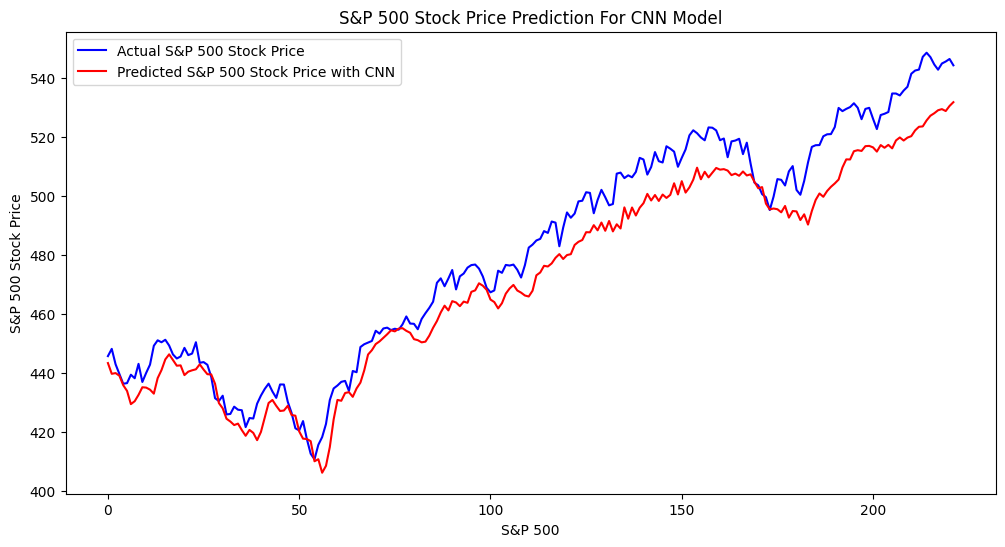

In [29]:
# Plotting a lineplot to visualize our actual and predicted values for the CNN Model
plt.figure(figsize=(12,6))
plt.plot(actual_prices, color='blue', label='Actual S&P 500 Stock Price')
plt.plot(cnn_prediction, color='red', label='Predicted S&P 500 Stock Price with CNN')
plt.title('S&P 500 Stock Price Prediction For CNN Model')
plt.xlabel('S&P 500')
plt.ylabel('S&P 500 Stock Price')
plt.legend()
plt.show()

# FORECASTING WITH OUR CNN MODEL FOR A 90 DAYS PERIOD

In [30]:
# Predict next 90 days
look_back = 30
days_to_predict = 90
future_days_cnn = predict_future_days(cnn_model, scaled_data, days_to_predict, scaler, look_back)

1/1 [==============================] - 0s 28ms/step


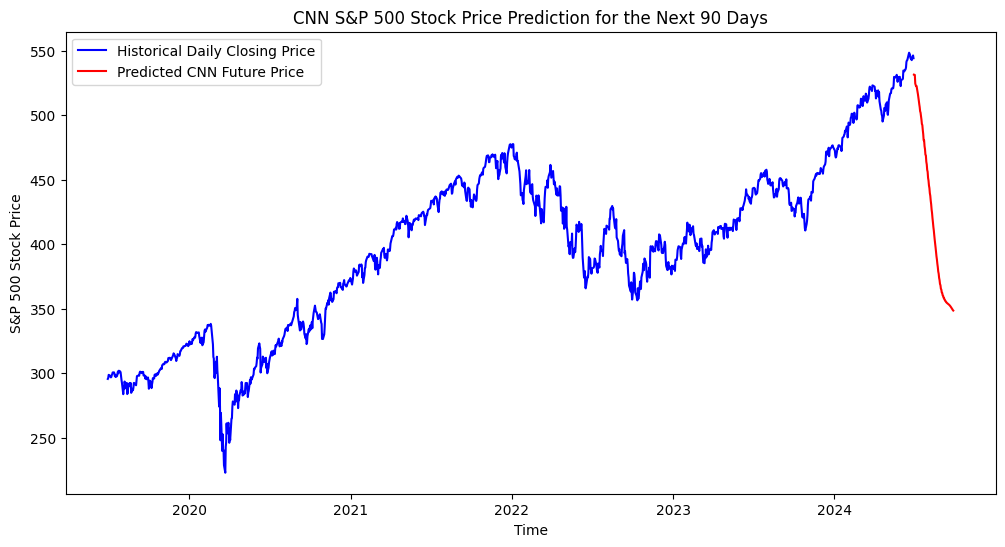

In [31]:
# Plot the predictions
predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, freq='D')[1:]
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], color='blue', label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days_cnn, color='red', label='Predicted CNN Future Price')
plt.title(f'CNN S&P 500 Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('S&P 500 Stock Price')
plt.legend()
plt.show()

# ARIMA MODEL

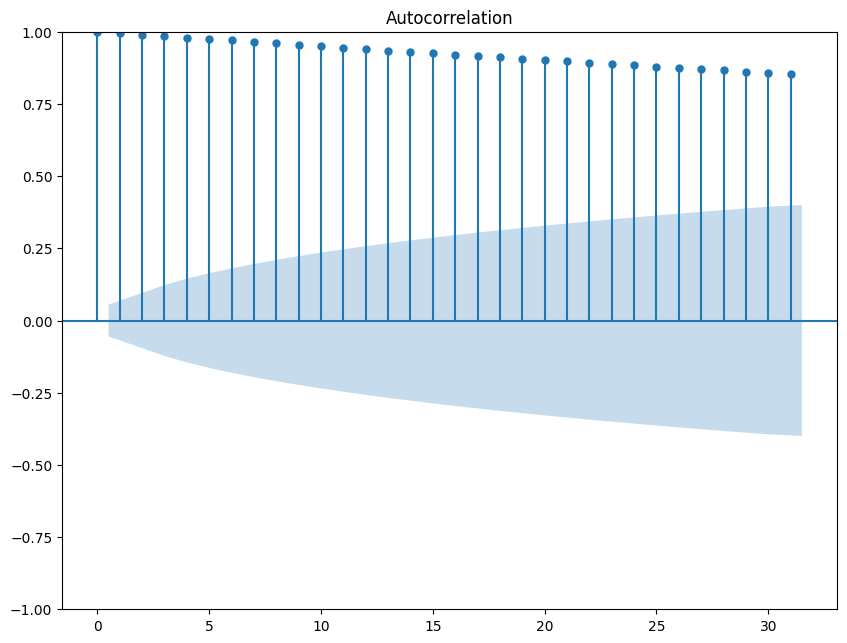

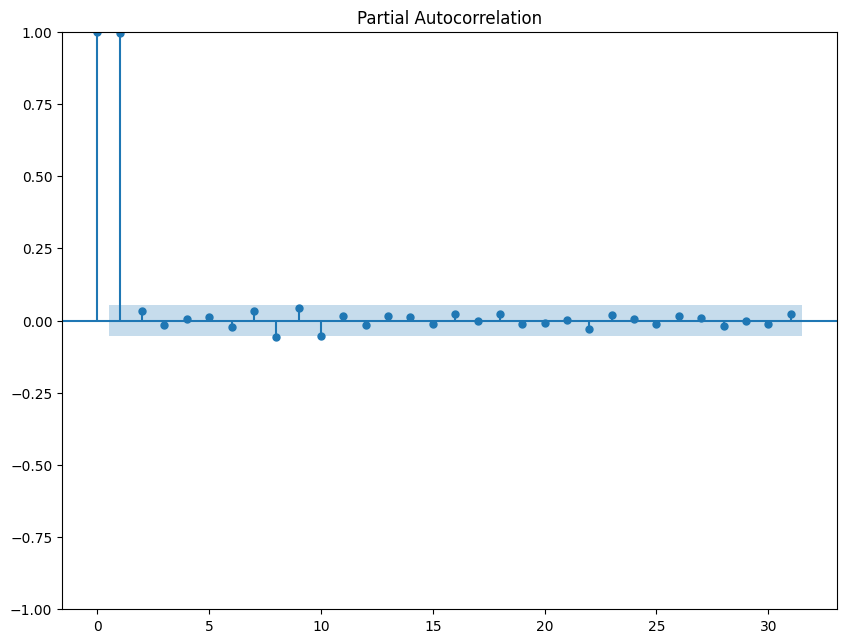

In [32]:
# Checking the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
acf_plot = plot_acf(data['Close'])
pacf_plot = plot_pacf(data['Close'])

In [33]:
# Checking if the model is stationary using the Augmented Dickey-Fuller (ADF) test
adf = adfuller(data['Close'])
print(f'p-value: {adf[1]}')  # If the p-value is greater than 0.05, it suggests the data is not stationary


p-value: 0.8458605437507476


In [34]:
# Making the data stationary by taking the log and differencing

# taking the log to stabilize the variance
data_log = np.log(data['Close'])
data_log

Date
2019-07-01    5.689210
2019-07-02    5.691811
2019-07-03    5.699774
2019-07-05    5.698636
2019-07-08    5.693126
                ...   
2024-06-24    6.296630
2024-06-25    6.300474
2024-06-26    6.301721
2024-06-27    6.303296
2024-06-28    6.299354
Name: Close, Length: 1258, dtype: float64

In [35]:
# using differencing to remove trend
data_log_diff =data_log.diff().dropna()
data_log_diff.head()

Date
2019-07-02    0.002601
2019-07-03    0.007963
2019-07-05   -0.001139
2019-07-08   -0.005510
2019-07-09    0.001246
Name: Close, dtype: float64

Text(0.5, 1.0, 'S & P 500 Stock Figure')

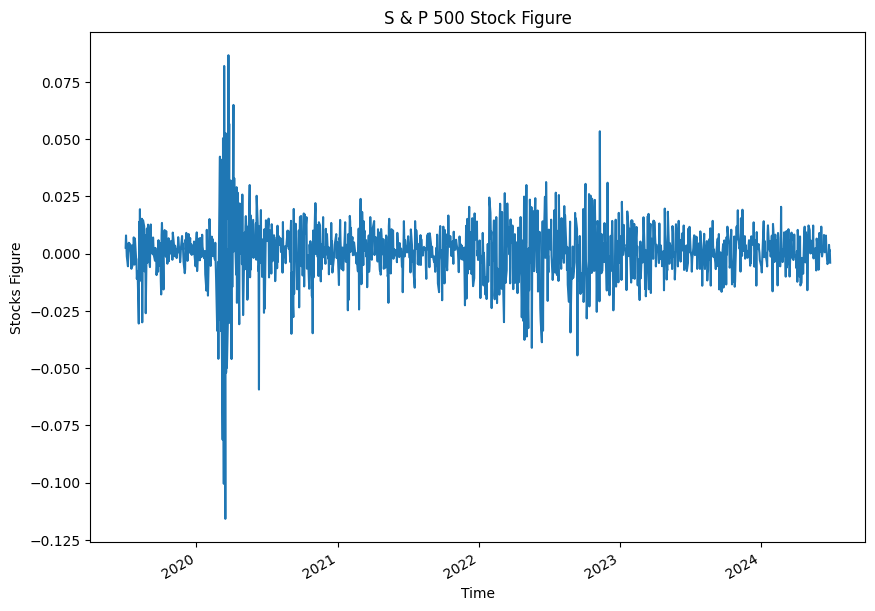

In [36]:
# Checking the plot after applying logarithmic transformation and differencing
data_log_diff.plot()
plt.xlabel('Time')  # Labeling the x-axis as Time
plt.ylabel('Stocks Figure')  # Labeling the y-axis as Sales Figure
plt.title('S & P 500 Stock Figure')  # Setting the title for the plot

In [37]:
# Confirming the stationarity with the adfuller test after making the data stationary
st=adfuller(data_log_diff)
print(f'p-value: {st[1]}')

p-value: 1.4756667663306048e-18


In [38]:
# Finding the best ARMA(p,q) model fit using the pmdarima automated best model fit finder
auto_data = pm.auto_arima(data['Close'], trace=True)
auto_data.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7369.242, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7418.063, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7410.668, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7411.267, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7418.364, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7413.263, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7413.321, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7406.190, Time=1.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7407.534, Time=2.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7411.538, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7414.429, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7414.664, Time=0.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7372.628, Time=2.82 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7369.859, Time=1.41 sec

Best model:  ARIMA(2,1,2)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3678.621
Date:                Wed, 17 Jul 2024   AIC                           7369.242
Time:                        16:11:43   BIC                           7400.061
Sample:                             0   HQIC                          7380.825
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7234      0.465      1.555      0.120      -0.189       1.635
ar.L1         -1.7679      0.030    -58.230      0.000      -1.827      -1.708
ar.L2         -0.8881      0.029    -31.142      0.000      -0.944      -0.832
ma.L1          1.7056      0.038     44.371      0.000       1.630       1.781
ma.L2          0.8031      0.037     21.873      0.000       0.731       0.875
sigma2        20.3870      0.560     36.390      0.000      19.289      21.485
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               535.78
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Johnson & Johnson ARIMA Model Building, Prediction, and Evaluation

In [40]:
# Build the ARIMA model
model = pm.auto_arima(train['Close'], seasonal=False, stepwise=True, suppress_warnings=True)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2993.370
Date:                Wed, 17 Jul 2024   AIC                           5996.740
Time:                        16:11:58   BIC                           6021.304
Sample:                             0   HQIC                          6006.074
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7638      0.033    -53.383      0.000      -1.829      -1.699
ar.L2         -0.8863      0.031    -28.673      0.000      -0.947      -0.826
ma.L1          1.6914      0.043     39.705      0.0

In [41]:
# Making predictions with the trained model
start_index = len(train)
end_index = len(train) + len(test) - 1
pred = model.predict(start=start_index, end=end_index, type='levels')

print(pred.head())


1006    437.337075
1007    436.552813
1008    437.096655
1009    436.832564
1010    436.816332
dtype: float64


In [42]:
# Making predictions with the trained model
n_periods = len(test)
pred, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

print(pred[:5])

# Align the test and prediction series
test_values = test['Close'].values



1006    437.337075
1007    436.552813
1008    437.096655
1009    436.832564
1010    436.816332
dtype: float64


In [43]:
# Calculate evaluation metrics
mae = mean_absolute_error(test_values, pred)
rmse = np.sqrt(mean_squared_error(test_values, pred))
r2 = r2_score(test_values, pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

MAE: 43.151380949859266
RMSE: 55.02001245178716
R-squared: -1.1856056377855855


In [44]:
# building on the full dataset
final_model=ARIMA(data['Close'],
                        order=(2,1,2),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
final_model=final_model.fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1258
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3673.766
Date:                Wed, 17 Jul 2024   AIC                           7357.532
Time:                        16:11:59   BIC                           7383.202
Sample:                             0   HQIC                          7367.181
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7637      0.031    -56.913      0.000      -1.824      -1.703
ar.L2         -0.8848      0.029    -30.433      0.000      -0.942      -0.828
ma.L1          1.6993      0.039     43.246      0.000       1.622       1.776
ma.L2          0.7974      0.037     21.277      0.000       0.724       0.871
sigma2        20.4749      0.551     37.151      0.000      19.395      21.555
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               526.44
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Specifying the range of forecast
start = len(data)-1
end = start + 90 - 1

# Perform the forecast
pred_result_f = final_model.get_prediction(start=start, end=end, dynamic=False, typ='levels')

# Accessing the predicted mean
pred_final_f = pred_result_f.predicted_mean.rename(' 90  period Forecast')

# Generate the index for future dates and assign it to the forecast
index_future_dates = pd.date_range(start='2024-06-28 ', periods=90, freq='D')
pred_final_f.index = index_future_dates

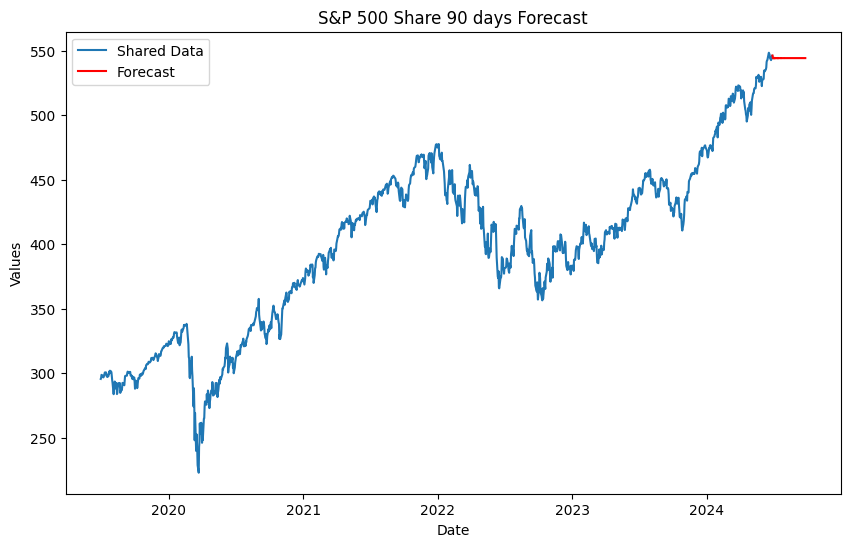

In [46]:
# Plotting the data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Shared Data')  #
plt.plot(pred_final_f.index, pred_final_f, label='Forecast', color='red')
plt.title('S&P 500 Share 90 days Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()